In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from ultralytics import YOLO
from inference_sdk import InferenceHTTPClient

# =========================
# 1. Load Image for Detection
# =========================
image_path = "/Users/amanchandel/Work/projects/MCV2/floorplans/9.png"  # Replace with your image path
image = cv2.imread(image_path)

# =========================
# 2. Set up Inference Client
# =========================
model_path = "/Users/amanchandel/Work/projects/MCV2/datasets/runs/detect/train/weights/best.pt"  # Path to your trained YOLO model
model = YOLO(model_path)


results = model.predict(source=image_path, conf=0.2)  # Adjust confidence threshold if needed
detections = results[0].boxes  # Extract detected boxes






image 1/1 /Users/amanchandel/Work/projects/MCV2/floorplans/9.png: 640x640 2 doors, 1 window, 5 zones, 29.4ms
Speed: 1.3ms preprocess, 29.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


In [82]:
coordinates = []

# Access results for the first image
detections = results[0].boxes  # Bounding box predictions
class_names = model.names  # Class names dictionary

for box in detections:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
    class_id = int(box.cls[0])  # Class index
    confidence = float(box.conf[0])  # Confidence score
    label = class_names[class_id]  # Class name from YOLO model

    coordinates.append({
        'x1': x1,
        'y1': y1,
        'x2': x2,
        'y2': y2,
        'class': label,
        'confidence': confidence
    })

print("Detected Object Coordinates:", coordinates)


Detected Object Coordinates: [{'x1': 88, 'y1': 180, 'x2': 168, 'y2': 271, 'class': 'zone', 'confidence': 0.9436659216880798}, {'x1': 117, 'y1': 269, 'x2': 154, 'y2': 279, 'class': 'window', 'confidence': 0.6285417675971985}, {'x1': 147, 'y1': 179, 'x2': 168, 'y2': 206, 'class': 'door', 'confidence': 0.6062602400779724}, {'x1': 88, 'y1': 59, 'x2': 137, 'y2': 98, 'class': 'zone', 'confidence': 0.5654322504997253}, {'x1': 91, 'y1': 102, 'x2': 138, 'y2': 158, 'class': 'zone', 'confidence': 0.4727652072906494}, {'x1': 147, 'y1': 59, 'x2': 168, 'y2': 83, 'class': 'door', 'confidence': 0.3088970184326172}, {'x1': 75, 'y1': 56, 'x2': 259, 'y2': 291, 'class': 'zone', 'confidence': 0.295580118894577}, {'x1': 268, 'y1': 2, 'x2': 347, 'y2': 338, 'class': 'zone', 'confidence': 0.23307989537715912}]


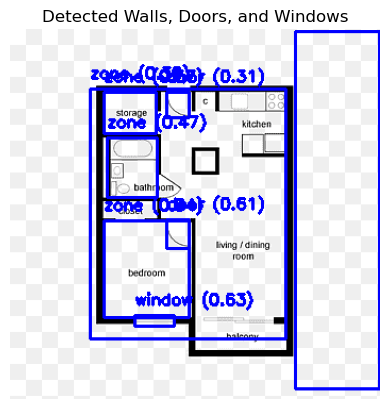

In [84]:
for item in coordinates:
    x1, y1, x2, y2 = item['x1'], item['y1'], item['x2'], item['y2']
    class_name = item['class']
    color = (0, 255, 0) if class_name.lower() == 'wall' else (255, 0, 0)  # Green for wall, Red for others

    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(image, f"{class_name} ({item['confidence']:.2f})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Walls, Doors, and Windows")
plt.axis("off")
plt.show()


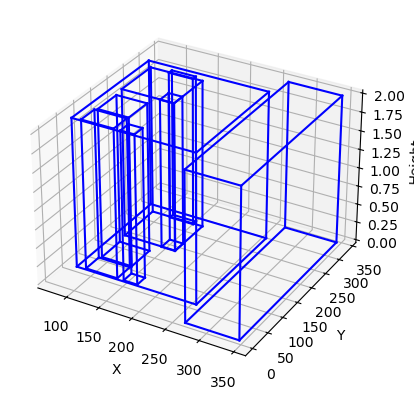

In [86]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Example: Plot detected objects as 3D boxes
for item in coordinates:
    x1, y1, x2, y2 = item['x1'], item['y1'], item['x2'], item['y2']
    label = item['class']
    
    # Define box height based on class
    height = 3 if label.lower() == 'wall' else 2
    
    # Create vertices for the 3D cuboid
    vertices = [
        [x1, y1, 0], [x2, y1, 0], [x2, y2, 0], [x1, y2, 0],  # Bottom face
        [x1, y1, height], [x2, y1, height], [x2, y2, height], [x1, y2, height]  # Top face
    ]

    # Plot the cuboid (as a wireframe for simplicity)
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom edges
        (4, 5), (5, 6), (6, 7), (7, 4),  # Top edges
        (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges
    ]
    for edge in edges:
        xs, ys, zs = zip(*[vertices[edge[0]], vertices[edge[1]]])
        ax.plot(xs, ys, zs, color='b')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Height")
plt.show()


In [88]:
import json

# Save detection data to a JSON file
output_path = "detections.json"
with open(output_path, "w") as json_file:
    json.dump(coordinates, json_file, indent=4)

print(f"Detection data saved to {output_path}")


Detection data saved to detections.json
